In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

In [36]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# SCENARIO 1

**Load Dataset**

In [ ]:
df=pd.read_csv("../data/StudentsPerformance.csv")
print(df.head())    

   gender race/ethnicity parental level of education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female        group B             master's degree      standard   
3    male        group A          associate's degree  free/reduced   
4    male        group C                some college      standard   

  test preparation course  math score  reading score  writing score  
0                    none          72             72             74  
1               completed          69             90             88  
2                    none          90             95             93  
3                    none          47             57             44  
4                    none          76             78             75  


**Create Target Variable**

In [6]:
df["final_score"] = (
    df["math score"] +
    df["reading score"] +
    df["writing score"]
) / 3

**Simulate Missing Features**

In [7]:
np.random.seed(42)

df["study_hours"] = np.random.randint(1, 8, size=len(df))           
df["attendance"] = np.random.randint(60, 100, size=len(df))        
df["sleep_hours"] = np.random.randint(4, 9, size=len(df))         

**Feature Selection**

In [8]:
X = df.drop(columns=[
    "math score",
    "reading score",
    "writing score",
    "final_score"
])

y = df["final_score"]


**Identify Feature Types**

In [9]:
categorical_features = X.select_dtypes(include="object").columns
numerical_features = X.select_dtypes(exclude="object").columns

**Preprocessing Pipeline**

In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(drop="first"), categorical_features)
    ]
)

**Train–Test Split**

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

**Train Multilinear Regression Model**

In [12]:
model = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("regressor", LinearRegression())
])

model.fit(X_train, y_train)

,steps,"[('preprocessing', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


**Prediction**

In [13]:
y_pred = model.predict(X_test)

**Model Evaluation**

In [14]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MSE :", mse)
print("RMSE:", rmse)
print("R²  :", r2)

MSE : 181.8174556875542
RMSE: 13.483970323593649
R²  : 0.15183856085975078


**Regression Coefficients**

In [15]:
feature_names = (
    numerical_features.tolist() +
    model.named_steps["preprocessing"]
         .transformers_[1][1]
         .get_feature_names_out(categorical_features).tolist()
)

coefficients = model.named_steps["regressor"].coef_

coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
}).sort_values(by="Coefficient", ascending=False)

coef_df.head(10)


,Feature,Coefficient
13,lunch_standard,9.210343
7,race/ethnicity_group E,6.147183
6,race/ethnicity_group D,3.851054
8,parental level of education_bachelor's degree,3.480108
10,parental level of education_master's degree,1.920988
5,race/ethnicity_group C,1.047609
0,study_hours,-0.061857
4,race/ethnicity_group B,-0.100344
2,sleep_hours,-0.210613
1,attendance,-0.738503


**Optimization – Ridge Regression**

In [16]:
ridge = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("regressor", Ridge(alpha=1.0))
])

ridge.fit(X_train, y_train)


,steps,"[('preprocessing', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


**Optimization – Lasso Regression**

In [17]:
lasso = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("regressor", Lasso(alpha=0.01))
])

lasso.fit(X_train, y_train)

,steps,"[('preprocessing', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Visualizations

- **Predicted vs Actual**

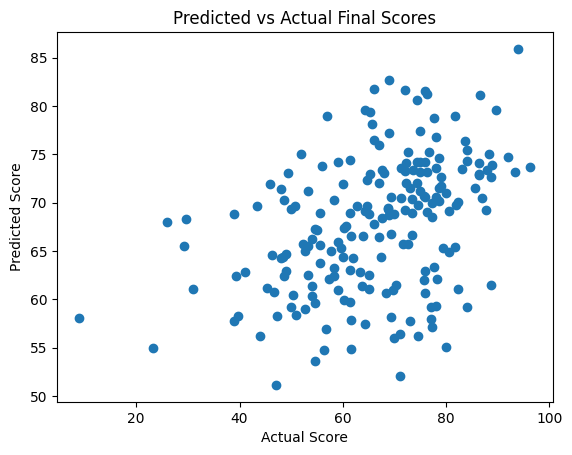

In [18]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Score")
plt.ylabel("Predicted Score")
plt.title("Predicted vs Actual Final Scores")
plt.show()

- **Coefficient Magnitude**

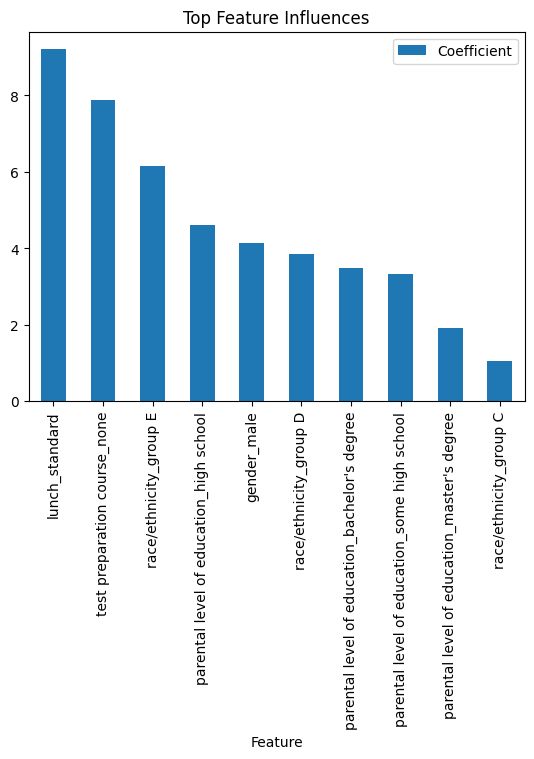

In [19]:
coef_df.set_index("Feature").abs().sort_values(
    by="Coefficient", ascending=False
).head(10).plot(kind="bar")

plt.title("Top Feature Influences")
plt.show()

- **Residual Distribution**

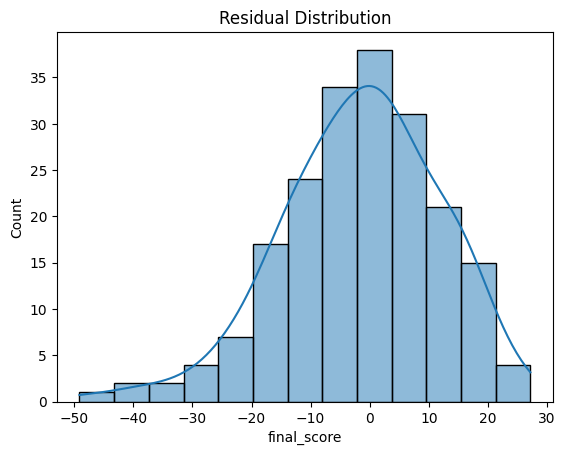

In [20]:
residuals = y_test - y_pred
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.show()

# SCENARIO 2

**Load Dataset**

In [25]:
df = pd.read_csv("../data/auto-mpg.csv")
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


**Clean the Dataset** <br/>
 Convert horsepower to numeric

In [26]:
df["horsepower"] = df["horsepower"].replace("?", np.nan)
df["horsepower"] = df["horsepower"].astype(float)

**Handle Missing Values**

In [28]:
df["horsepower"].fillna(df["horsepower"].mean(), inplace=True)

C:\Users\nisha\AppData\Local\Temp\ipykernel_30240\666407550.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["horsepower"].fillna(df["horsepower"].mean(), inplace=True)


**Feature & Target Selection**

In [29]:
X = df[["horsepower"]]
y = df["mpg"]

**Train–Test Split**

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

**Feature Scaling**

In [32]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


**Polynomial Regression Function**

In [33]:
def polynomial_model(degree):
    poly = PolynomialFeatures(degree=degree)
    
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_test_poly = poly.transform(X_test_scaled)
    
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    
    y_pred = model.predict(X_test_poly)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    return model, poly, mse, rmse, r2


**Train Models**

In [37]:
results = {}

for d in [2, 3, 4]:
    model, poly, mse, rmse, r2 = polynomial_model(d)
    results[d] = {"MSE": mse, "RMSE": rmse, "R2": r2}

results_df = pd.DataFrame(results).T
results_df


,MSE,RMSE,R2
2,13.760855,3.709563,0.744062
3,13.813374,3.716635,0.743086
4,14.118024,3.757396,0.737419


**Model Comparison**
Typical Outcome
| **Degree** | **Behavior**                    |
| ------ | --------------------------- |
| 1      | Underfitting                |
| 2      | Good bias-variance tradeoff |
| 3      | Better fit                  |
| 4      | Overfitting risk            |

**Polynomial Curve Visualization**

c:\Users\nisha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


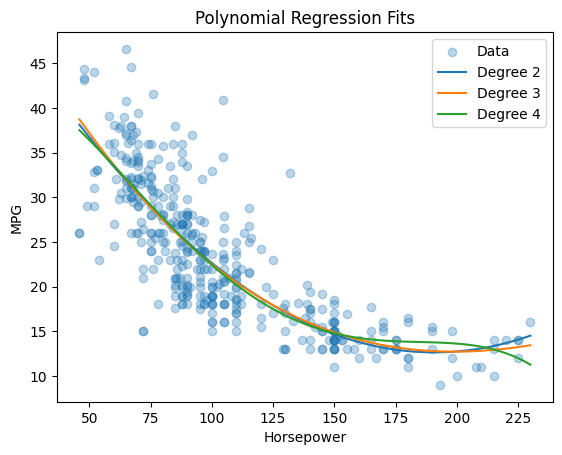

In [38]:
X_range = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
X_range_scaled = scaler.transform(X_range)

plt.scatter(X, y, alpha=0.3, label="Data")

for d in [2, 3, 4]:
    poly = PolynomialFeatures(d)
    X_poly = poly.fit_transform(X_train_scaled)
    model = LinearRegression()
    model.fit(X_poly, y_train)
    
    y_curve = model.predict(poly.transform(X_range_scaled))
    plt.plot(X_range, y_curve, label=f"Degree {d}")

plt.xlabel("Horsepower")
plt.ylabel("MPG")
plt.title("Polynomial Regression Fits")
plt.legend()
plt.show()


**Train vs Test Error (Overfitting Proof)**

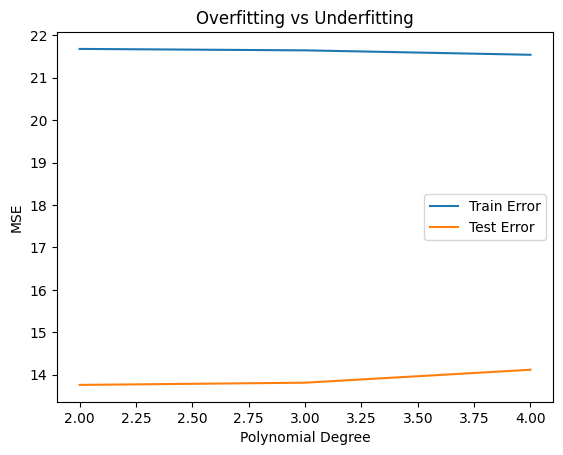

In [39]:
train_errors = []
test_errors = []

for d in [2, 3, 4]:
    poly = PolynomialFeatures(d)
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_test_poly = poly.transform(X_test_scaled)
    
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    
    train_errors.append(mean_squared_error(
        y_train, model.predict(X_train_poly)))
    
    test_errors.append(mean_squared_error(
        y_test, model.predict(X_test_poly)))

plt.plot([2,3,4], train_errors, label="Train Error")
plt.plot([2,3,4], test_errors, label="Test Error")
plt.xlabel("Polynomial Degree")
plt.ylabel("MSE")
plt.title("Overfitting vs Underfitting")
plt.legend()
plt.show()


**Ridge Regression (Overfitting Control)**

In [40]:
poly = PolynomialFeatures(degree=4)

X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

ridge = Ridge(alpha=10)
ridge.fit(X_train_poly, y_train)

y_pred_ridge = ridge.predict(X_test_poly)

print("Ridge RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_ridge)))
print("Ridge R2:", r2_score(y_test, y_pred_ridge))


Ridge RMSE: 3.7030791028888914
Ridge R2: 0.744956261083338
